In [1]:
def plot_sed(x, y, yerr):
    plt.clf()
    plt.errorbar(wavelength, flux, yerr=flux_err, c='red', ecolor='gray', capthick=2)
    plt.show()

# Libraries

In [2]:
# usual libraries ----------------------------------------------------------------------------------------------------
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import seaborn           as sns
import astropy.io.fits   as pf
import astropy.constants as ct
import os
import time
import scipy.interpolate as sci
import ipywidgets        as widgets

In [3]:
# ppxf separately ----------------------------------------------------------------------------------------------------
import ppxf.miles_util   as lib  # MILES library embedded in ppxf
import ppxf.ppxf_util    as util
import ppxf              as ppxf_module
from ppxf.ppxf           import ppxf
from ppxf.ppxf_util      import log_rebin

# Dataset

In [4]:
dataset_path = './../../Catalogue/Match08_smallemlines_inputcattype.csv'
my_data      = pd.read_csv(dataset_path)

In [5]:
whan_class = my_data['WHAN_CLASS'].values.astype(str)
uv_class   = my_data['UV_CLASS_YI2011'].values.astype(str)
cataid     = my_data['CATAID'].values.astype(str)
specid     = my_data['SPECID'].values.astype(str)
s2n        = my_data['S2N'].values.astype(float)
chi2_gama  = my_data['CHI2'].values.astype(float)
redshift   = my_data['Z'].values.astype(float)

In [ ]:
uv_unique   = np.unique(uv_class, return_counts=True)
whan_unique = np.unique(whan_class, return_counts=True)
print (uv_unique, '\n', whan_unique)

(array(['RSF', 'UV_UPTURN', 'UV_WEAK'], dtype='<U9'), array([13840,   210,   296])) 
 (array(['Retired/Passive', 'SF', 'nan', 'sAGN', 'wAGN'], dtype='<U15'), array([ 876, 9408, 1285, 2184,  593]))


In [ ]:
idx_uvup_rp = np.where((uv_class=='UV_UPTURN')*(whan_class=='Retired/Passive'))

## Plot the distributions of S/N

### Plot settings (yes, I'm lazy)

In [ ]:
bins = 20
palette = ['#a6611a','#dfc27d','#80cdc1','#018571']
sns.set_style("white")
plt.rcParams["axes.edgecolor"] = "0.15"
plt.rcParams["axes.linewidth"] = 1.

### Histogram - S/N and $\chi^2$

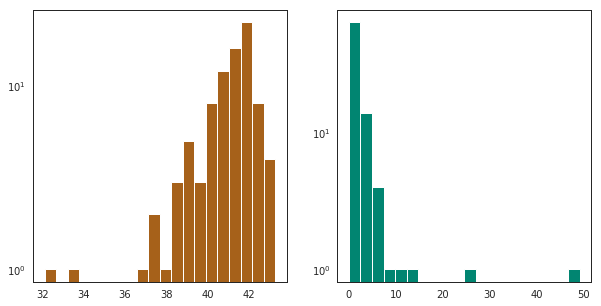

In [ ]:
plt.subplots(figsize=(10,5))
plt.subplot(1,2,1)
plt.hist(s2n[idx_uvup_rp], bins=bins, color=palette[0])
plt.yscale('log')
plt.subplot(1,2,2)
plt.hist(chi2_gama[idx_uvup_rp], bins=bins, color=palette[3])
plt.yscale('log')
plt.show()

### Selecting top 10 objects with the best S2N

In [ ]:
best_s2n_10 = np.argsort(s2n[idx_uvup_rp])[-10:-1]

In [ ]:
s2n_top10 = s2n[idx_uvup_rp][best_s2n_10]    # top 10 objects given the S/N

In [ ]:
chi2_top   = chi2_gama[idx_uvup_rp][best_s2n_10]
specid_top = specid[idx_uvup_rp][best_s2n_10]

# pPXF

## Configuring inputs

In [ ]:
ppxf_dir     = os.path.dirname(os.path.realpath(ppxf_module.__file__))
miles_lib    = ppxf_dir+'/miles_models/Mun1.30*.fits'
seds_path   = './../../../../GAMADR3_SPECTRA/DATABASE/'
results_path = './Results/'

light_speed  = float(str(ct.c.to('km/s')).split(' ')[0])            # selecting the numerical values (must be in km/s)

In [ ]:
seds_list = []
for i in specid_top: seds_list.append(i+'.fit')

In [ ]:
bar = widgets.IntProgress(value=0, min=0, max=len(seds_list)+1, step=0.5, description='Running pPXF:',
                          orientation='horizontal')
display(bar)

IntProgress(value=0, description='Running pPXF:', max=10)

### pPXF plot settings

In [ ]:
palette      = ['#ef8a62','#f7f7f7','#67a9cf']
transparency = 0.8
lw           = 2.

## pPXF settings

In [ ]:
# Fit (V, sig, h3, h4) moments=4 for the stars; (V, sig) moments=2 for the two gas kinematic components
moments        = [4, 2, 2]
degree         = -1         # Additive Legendre polynomial degrees
mdegree        = 300        # Multiplicative Legendre polynomial degrees
regul_err      = 0.013      # Desired regularization error -- TODO: MUST CHECK WHY 0.013
tied_balmer    = True
limit_doublets = False
stellar_comp_w = [0]        # weight of the stellar component
balmer_comp_w  = [1]        # weight of the balmer emission lines
forbid_comp_w  = [2]        # weight of the forbidden lines
# wl_min         = 3540       # MILES RANGE MIN
# wl_max         = 7409       # MILES RANGE MAX
wl_min = 4350            # removing the bluest part of the spectra in order to mitigate noise effects
wl_max = 7409

In [ ]:
mean_age   = ['<logAge>']
mean_metal = ['<[M/H]>']
mass2light = ['MASS2LIGHT_R']
ids        = ['CATAID']
redshifts  = ['Z']

/home/mlldantas/anaconda3/envs/py3k6/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


Emission lines included in gas templates:
['Balmer' '[OII]3726' '[OII]3729' '[OIII]5007_d']
Best Fit:       Vel     sigma        h3        h4
 comp. 0:     51800       778    -0.300     0.300
 comp. 1:     47800      1000
 comp. 2:     51800      1000
chi2/DOF: 0.005016
method = capfit ; Jac calls: 45 ; Func calls: 13965 ; Status: 2
Gas Reddening E(B-V): 10.000
Nonzero Templates:  64  /  154
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component   name       flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp: 1       Unknown      44.58       5.6   47800  1000
Comp: 2       Unknown      82.43        48   51800  1000
Comp: 2       Unknown          0        38   51800  1000
Comp: 2       Unknown          0        10   51800  1000
---------------------------------------------------------
Weighted <logAge> [yr]: 9.93
Weighted <[M/H]>: -0.196
Weighted <logAge> [yr]: 9.93
Weighted <[M/H]>: -0.196
M/L_r: 3.499
Current $\chi^2$: 0.0050


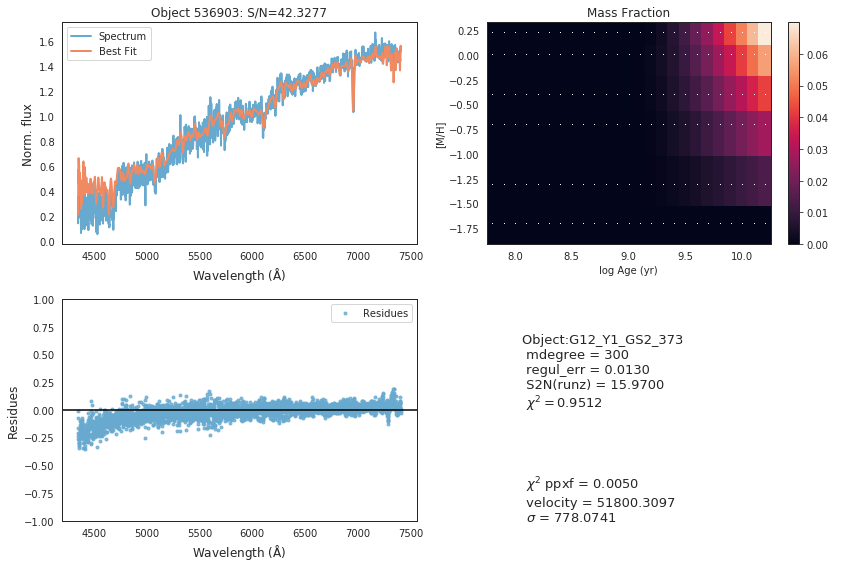

Emission lines included in gas templates:
['Balmer' '[OII]3726' '[OII]3729' '[OIII]5007_d']
Best Fit:       Vel     sigma        h3        h4
 comp. 0:     56494       979     0.105     0.078
 comp. 1:     56507         1
 comp. 2:     56840       176
chi2/DOF: 0.002951
method = capfit ; Jac calls: 15 ; Func calls: 4655 ; Status: 2
Gas Reddening E(B-V): 0.043
Nonzero Templates:  86  /  154
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component   name       flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp: 1       Unknown          0       3.1   56507     1
Comp: 2       Unknown      1.459         6   56840   176
Comp: 2       Unknown      1.858         6   56840   176
Comp: 2       Unknown          0       5.7   56840   176
---------------------------------------------------------
Weighted <logAge> [yr]: 9.85
Weighted <[M/H]>: -0.198
Weighted <logAge> [yr]: 9.85
Weighted <[M/H]>: -0.198
M/L_r: 2.815
Current $\chi^2$: 0.0030
El

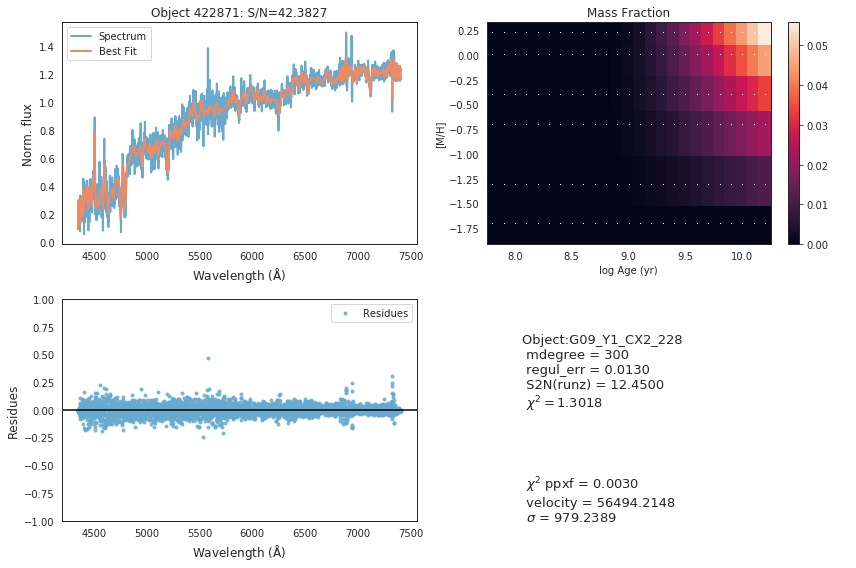

Emission lines included in gas templates:
['Balmer' '[OII]3726' '[OII]3729' '[OIII]5007_d']
Best Fit:       Vel     sigma        h3        h4
 comp. 0:     51560       492     0.040     0.232
 comp. 1:     51368       249
 comp. 2:     51653       180
chi2/DOF: 0.01317
method = capfit ; Jac calls: 9 ; Func calls: 2793 ; Status: 2
Gas Reddening E(B-V): 7.296
Nonzero Templates:  127  /  154
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component   name       flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp: 1       Unknown     0.7716       1.9   51368   249
Comp: 2       Unknown          0        11   51653   180
Comp: 2       Unknown          0        10   51653   180
Comp: 2       Unknown          0       4.6   51653   180
---------------------------------------------------------
Weighted <logAge> [yr]: 9.83
Weighted <[M/H]>: -0.6
Weighted <logAge> [yr]: 9.83
Weighted <[M/H]>: -0.6
M/L_r: 2.037
Current $\chi^2$: 0.0132
Elapsed

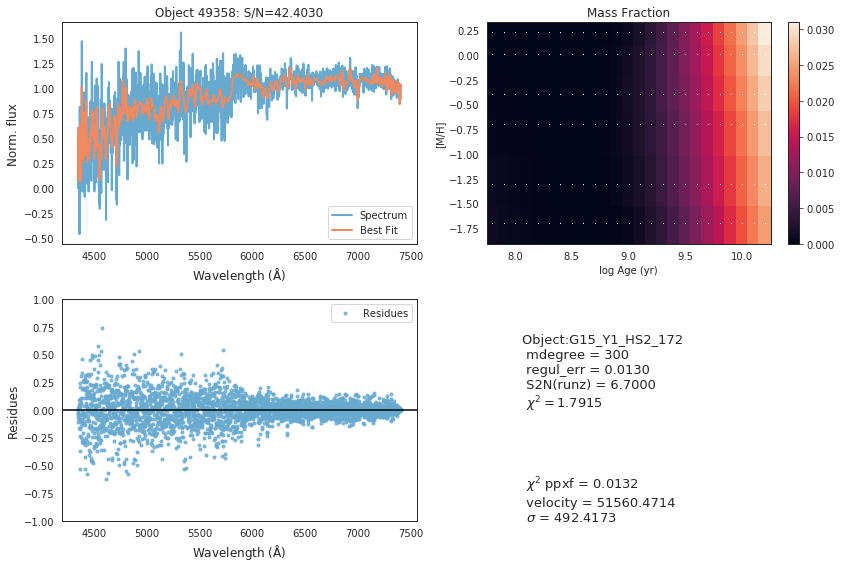

Emission lines included in gas templates:
['Balmer' '[OII]3726' '[OII]3729' '[OIII]5007_d']
Best Fit:       Vel     sigma        h3        h4
 comp. 0:     70387       440     0.025     0.009
 comp. 1:     69745        43
 comp. 2:     69889       180
chi2/DOF: 0.004451
method = capfit ; Jac calls: 11 ; Func calls: 3412 ; Status: 2
Gas Reddening E(B-V): 0.000
Nonzero Templates:  92  /  154
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component   name       flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp: 1       Unknown     0.6549       3.5   69745    43
Comp: 2       Unknown          0       6.3   69889   180
Comp: 2       Unknown          0       6.3   69889   180
Comp: 2       Unknown          0       3.5   69889   180
---------------------------------------------------------
Weighted <logAge> [yr]: 9.83
Weighted <[M/H]>: -0.217
Weighted <logAge> [yr]: 9.83
Weighted <[M/H]>: -0.217
M/L_r: 2.625
Current $\chi^2$: 0.0045
El

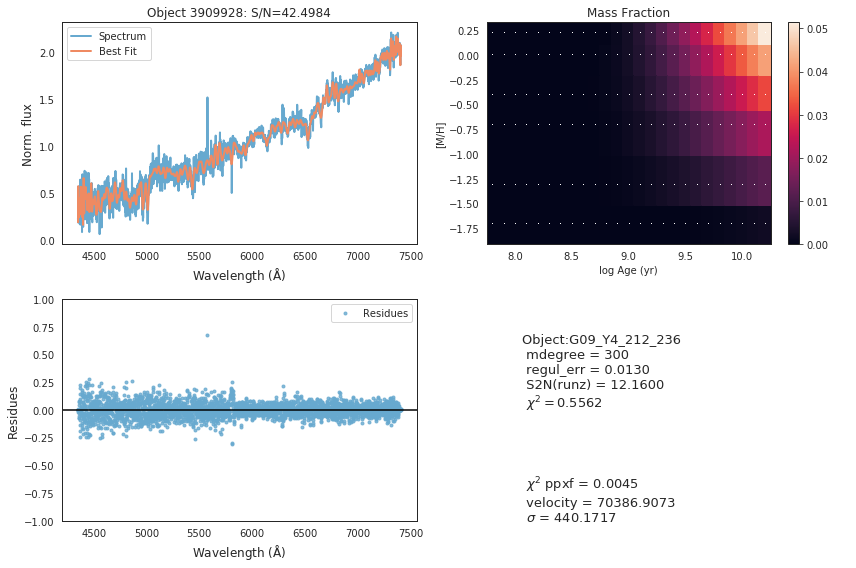

Emission lines included in gas templates:
['Balmer' '[OII]3726' '[OII]3729' '[OIII]5007_d']
Best Fit:       Vel     sigma        h3        h4
 comp. 0:     55069       825     0.013    -0.016
 comp. 1:     54867        23
 comp. 2:     54992       159
chi2/DOF: 0.007393
method = capfit ; Jac calls: 16 ; Func calls: 4964 ; Status: 2
Gas Reddening E(B-V): 0.000
Nonzero Templates:  106  /  154
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component   name       flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp: 1       Unknown     0.7416       2.5   54867    23
Comp: 2       Unknown      3.457       6.3   54992   159
Comp: 2       Unknown          0       6.1   54992   159
Comp: 2       Unknown      1.994       6.1   54992   159
---------------------------------------------------------
Weighted <logAge> [yr]: 9.8
Weighted <[M/H]>: -0.252
Weighted <logAge> [yr]: 9.8
Weighted <[M/H]>: -0.252
M/L_r: 2.374
Current $\chi^2$: 0.0074
Ela

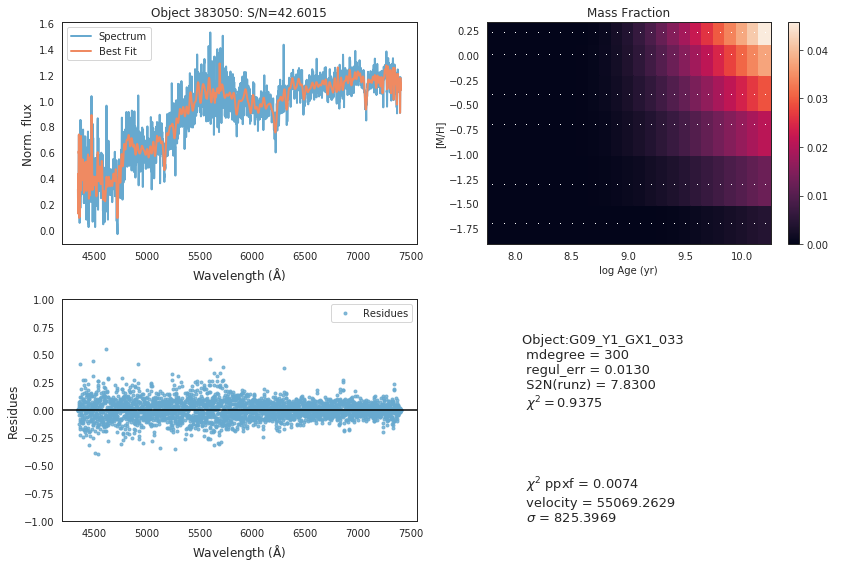

Emission lines included in gas templates:
['Balmer' '[OIII]5007_d' '[OI]6300_d']
Best Fit:       Vel     sigma        h3        h4
 comp. 0:     42957       988    -0.003    -0.027
 comp. 1:     43246       137
 comp. 2:     42993         1
chi2/DOF: 0.001525
method = capfit ; Jac calls: 14 ; Func calls: 4345 ; Status: 2
Gas Reddening E(B-V): 6.934
Nonzero Templates:  102  /  153
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component   name       flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp: 1       Unknown     0.3704       1.8   43246   137
Comp: 2       Unknown          0       2.5   42993     1
Comp: 2       Unknown          0       1.6   42993     1
---------------------------------------------------------
Weighted <logAge> [yr]: 9.8
Weighted <[M/H]>: -0.232
Weighted <logAge> [yr]: 9.8
Weighted <[M/H]>: -0.232
M/L_r: 2.4
Current $\chi^2$: 0.0015
Elapsed time in PPXF: 27.95 [min]


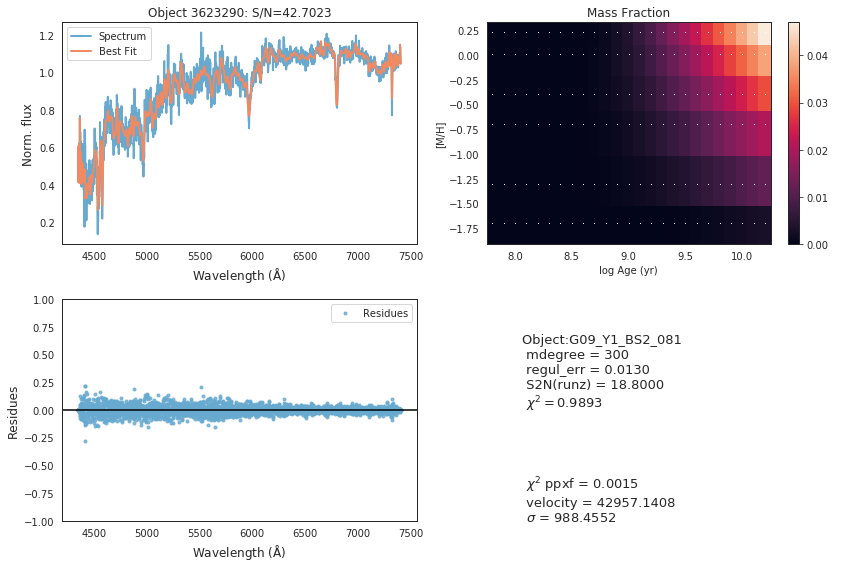

Emission lines included in gas templates:
['Balmer' '[OII]3726' '[OII]3729' '[OIII]5007_d' '[OI]6300_d']
Best Fit:       Vel     sigma        h3        h4
 comp. 0:     48576       353     0.300     0.300
 comp. 1:     49680      1000
 comp. 2:     45680      1000
chi2/DOF: 0.02978
method = capfit ; Jac calls: 28 ; Func calls: 8689 ; Status: 2
Gas Reddening E(B-V): 7.303
Nonzero Templates:  60  /  155
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component   name       flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp: 1       Unknown      54.67       7.7   49680  1000
Comp: 2       Unknown      26.77   1.1e+02   45680  1000
Comp: 2       Unknown          0     1e+02   45680  1000
Comp: 2       Unknown          0       8.8   45680  1000
Comp: 2       Unknown      64.39       8.7   45680  1000
---------------------------------------------------------
Weighted <logAge> [yr]: 9.95
Weighted <[M/H]>: -0.195
Weighted <logAge> [yr]: 9

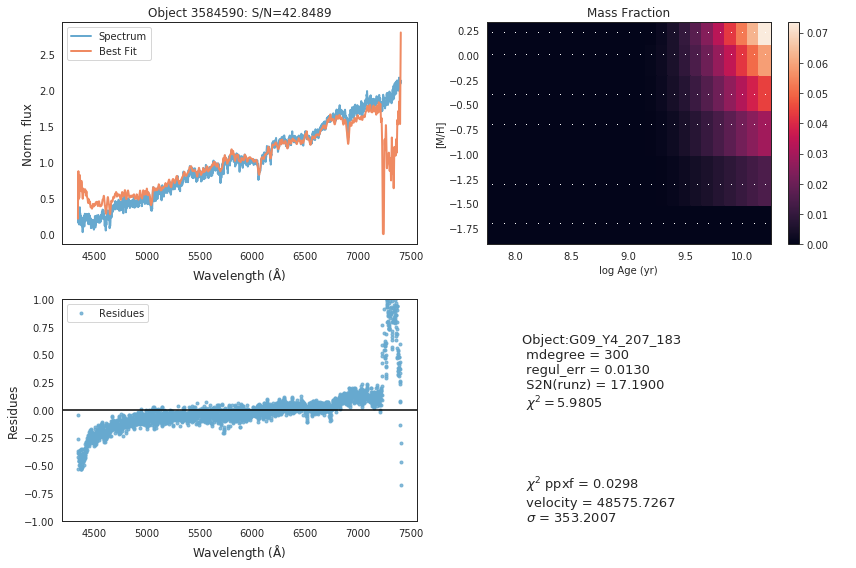

Emission lines included in gas templates:
['Balmer' '[OII]3726' '[OII]3729' '[OIII]5007_d']


In [ ]:
for each_sed in range(len(seds_list)):
    
    # settings for the progress bar widget above: does not influence in ppxf -----------------------------------------
    bar.value += each_sed/2.                                          # signal to increment the progress bar
    if each_sed<len(seds_list): 
        bar.bar_style = ""                                            # blue when in progress
    else: 
        bar.bar_style = "success"                                     # green when it finishes        
        
    # flux -----------------------------------------------------------------------------------------------------------
    sed_file  = os.path.join(seds_path, seds_list[each_sed])          # link between path and files
    sed_flux  = pf.getdata(sed_file)[0]                               # opening each spectra
    sed_err   = pf.getdata(sed_file)[1]                               # opening each spectra error
    
    # wavelength -----------------------------------------------------------------------------------------------------
    sed_header = pf.open(sed_file)[0].header
    sed_wl_ini = sed_header['WMIN'] 
    sed_wl_stp = sed_header['CD1_1']
    sed_wl     = np.arange(sed_flux.size)*(sed_wl_stp)+sed_wl_ini     # sed wavelength    
#     plot_sed(sed_wl, sed_flux, sed_err)
    
    # cleaning flux and wavelength trash -----------------------------------------------------------------------------
    idx_clean       = np.where((np.logical_not(np.isnan(sed_flux)))*(sed_err>0))    # indices where NAN is present
    flux_temp       = sed_flux[idx_clean]                                           # removing NAN values from spectra
    flux_temp_err   = sed_err[idx_clean]
    wavelength_temp = sed_wl[idx_clean]    
#     plot_sed(wavelength_temp, flux_temp, flux_temp_err)
    
    # limiting the spectrum regarding the wavelength range of the library --------------------------------------------
    wl_lib_idx = (wavelength_temp>wl_min) & (wavelength_temp<wl_max)       # MILES wavelength range
    flux       = flux_temp[wl_lib_idx]
    flux_err   = flux_temp_err[wl_lib_idx]
    wavelength = wavelength_temp[wl_lib_idx]    
#     plot_sed(wavelength, flux, flux_err)    
    
    # other important parameters -------------------------------------------------------------------------------------
    redshift  = sed_header['Z']
    cataid    = sed_header['CATAID']
    fwhm_gama = 3.
    
    # ppxf -----------------------------------------------------------------------------------------------------------
    vel_scale          = light_speed*np.log(wavelength[1]/wavelength[0])      # velocity scale - Eq.8 Capellari 2017
    
    ### setup templates ----------------------------------------------------------------------------------------------
    #### stellar pops ------------------------------------------------------------------------------------------------
    miles              = lib.miles(miles_lib, vel_scale, fwhm_gama)
    stellar_templates  = miles.templates.reshape(miles.templates.shape[0], -1)
    reg_dim            = miles.templates.shape[1:]
    dv                 = light_speed*(miles.log_lam_temp[0] - np.log(wavelength[0]))  # eq.(8) of Cappellari (2017)
    vel                = light_speed*np.log(1 + redshift)                             # eq.(8) of Cappellari (2017)
    start              = [vel, 180.]
    
    #### gas templates -----------------------------------------------------------------------------------------------
    wl_range_galaxy = np.array([np.min(wavelength), np.max(wavelength)])/(1 + redshift)
    gas_templates, gas_names, line_wave = util.emission_lines(miles.log_lam_temp, wl_range_galaxy, fwhm_gama, 
                                                              tie_balmer=tied_balmer, limit_doublets=limit_doublets)
    number_of_templates = stellar_templates.shape[1]
    number_of_forbidden = np.sum(["[" in a for a in gas_names])                      # forbidden lines contain "[*]"
    number_of_balmer    = len(gas_names) - number_of_forbidden
        
    component = (stellar_comp_w*number_of_templates)+(balmer_comp_w*number_of_balmer)+(forbid_comp_w
                                                                                       *number_of_forbidden)
        
    gas_component = np.array(component) > 0       # gas_component=True for gas templates
    start3        = [start, start, start]         # adopt the same starting value for the 3 components
    gas_reddening = 0 if tied_balmer else None    # If the Balmer lines are tied one should allow for gas reddening.
    
    
    #### all templates -----------------------------------------------------------------------------------------------
    all_templates = np.column_stack([stellar_templates, gas_templates])
    
    ### rebinning the spectrum so it is at the same size as the templates (or smaller) -------------------------------
    new_shape          = stellar_templates[:,0].shape
    rebinning_function = sci.interp1d(wavelength, flux)   # for the flux
    wavelength_rebin   = np.linspace(start=wavelength.min(), stop=wavelength.max(), num=int(new_shape[0]))
    flux_rebin         = rebinning_function(wavelength_rebin)
    
    ### rebinning the error ------------------------------------------------------------------------------------------
    rebin_func_error   = sci.interp1d(wavelength, flux_err)
    wl_rebin_error     = np.linspace(start=wavelength.min(), stop=wavelength.max(), num=int(new_shape[0]))
    flux_err_rebin     = rebin_func_error(wavelength_rebin)
    
    ### final galaxy spectrum and its error to be analysed -----------------------------------------------------------
    galaxy             = flux_rebin/np.median(flux_rebin)               # Normalize spectrum to avoid numerical issues
    noise              = flux_err_rebin/np.median(flux_err_rebin)       # idem
    
#     plot_sed(wavelength_rebin, galaxy, noise)    
    
    ### SED FITTING WITH PPXF ----------------------------------------------------------------------------------------
    start_time = time.clock()
    sed_fit = ppxf(templates=all_templates, galaxy=galaxy, noise=noise, velscale=vel_scale, start=start3, plot=False, 
                   lam=wavelength_rebin, moments=moments, degree=degree, mdegree=mdegree, regul=1./regul_err, 
                   reg_dim=reg_dim, vsyst=dv, clean=False, component=component, gas_component=gas_component,
                   gas_reddening=gas_reddening)
    end_time = time.clock()
    
    ## output parameters -- most of them will become a dataframe at the end of the script  
    residues = (galaxy-sed_fit.bestfit)
    
    stellar_weights = sed_fit.weights[~gas_component]                         # Exclude weights of the gas templates
    stellar_weights = stellar_weights.reshape(reg_dim)/stellar_weights.sum()  # Normalized
    
    velocity = sed_fit.sol[0][0]
    sigma    = sed_fit.sol[0][1]
    
    mean_age.append(miles.mean_age_metal(stellar_weights)[0])
    mean_metal.append(miles.mean_age_metal(stellar_weights)[1])
    mass2light.append(miles.mass_to_light(stellar_weights, band="r"))
    ids.append(cataid)
    redshifts.append(redshift)
       
    print(r"Current $\chi^2$: %.4f" % (sed_fit.chi2))
    print('Elapsed time in PPXF: %.2f [min]' % ((end_time-start_time)/60))
    
    ### Saving fit results -------------------------------------------------------------------------------------------
    output = {}
    output['wavelength'] = wavelength_rebin
    output['flux']       = sed_fit.galaxy
    output['best_fit']   = sed_fit.bestfit
    
    output_df = pd.DataFrame(output)
    output_df.to_csv(os.path.join('./Results/', 'fit_'+str(cataid)+'_'+str(mdegree)+'_'+str(wl_min)+'.csv'), 
                     index=False)

    ### Saving plots -------------------------------------------------------------------------------------------------
    plt.subplots(figsize=(12,8))
    
    #### plot01 ------------------------------------------------------------------------------------------------------
    plt.subplot(2,2,1)
    plt.plot(wavelength_rebin, sed_fit.galaxy, '-', color=palette[-1], linewidth=lw, label="Spectrum")
    plt.plot(wavelength_rebin, sed_fit.bestfit, '-', color=palette[0], linewidth=lw, label="Best Fit")
    plt.title("Object %s: S/N=%.4f" % (cataid, s2n_top10[each_sed]))
    plt.legend(loc='best')
    plt.xlabel("Wavelength ($\mathrm{\AA}$)", fontsize=12)
    plt.ylabel("Norm. flux", fontsize=12)
    
    #### plot02 ------------------------------------------------------------------------------------------------------
    plt.subplot(2,2,2)
    miles.plot(stellar_weights)
    
    #### plot03 ------------------------------------------------------------------------------------------------------
    plt.subplot(2,2,3)
    plt.plot(wavelength_rebin, residues, '.', color=palette[-1], linewidth=lw, label="Residues", alpha=transparency)
    plt.axhline(y=0, c='black')
    plt.legend(loc='best')
    plt.xlabel("Wavelength ($\mathrm{\AA}$)", fontsize=12)
    plt.ylabel("Residues", fontsize=12)
    plt.ylim([-1,1])
    
    #### plot04 ------------------------------------------------------------------------------------------------------
    plt.subplot(2,2,4)
    plt.text(0.1, 0.5, "Object:{:s} \n mdegree = {:d} \n regul_err = {:.4f}\n S2N(runz) = {:.4f} \n $\chi^2 = ${:.4f}"
             .format(sed_header['SPECID'], mdegree, regul_err, sed_header['SN'], chi2_top[each_sed]), 
             fontsize=13)
    plt.text(0.1, 0.0, " \n $\chi^2$ ppxf = {:.4f} \n velocity = {:.4f} \n $\sigma$ = {:.4f}"
             .format(sed_fit.chi2, velocity, sigma), fontsize=13)
    plt.axis('off') 
    
    plt.tight_layout()
    plt.savefig(os.path.join('./Results/', 'gal_'+str(cataid)+'_'+str(mdegree)+'_'+str(wl_min)+'.png'))
    plt.show()

In [ ]:
### Saving outputs as dataframe ----------------------------------------------------------------------------------
ids        = np.array(ids)
redshifts  = np.array(redshifts)
mean_age   = np.array(mean_age)
mean_metal = np.array(mean_metal)
mass2light = np.array(mass2light)
outputs    = np.column_stack((ids, redshifts, mean_age, mean_metal, mass2light))
columns    = outputs[0,:]
outputs_dataframe = pd.DataFrame(outputs[1:,:])
outputs_dataframe.columns = columns
outputs_dataframe.to_csv('./Results/'+'ouputs_ppxf_'+str(mdegree)+'_'+str(wl_min)+'.csv', index=False)